In [1]:
from collections import Counter
import pickle
from functools import partial

import pandas as pd
import numpy as np
import scipy

from statsmodels.formula.api import ols

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output

%matplotlib inline

In [2]:
from sklearn.cross_validation import StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.regularizers import WeightRegularizer, l1, l2
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, ELU, LeakyReLU
from keras.callbacks import EarlyStopping, Callback

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
class WatchlistCallback(Callback):
    def __init__(self, watchlist, eval_metric, epoch_no=10):
        super(Callback, self).__init__()

        self.epoch_no = epoch_no
        self.X, self.y = watchlist
        self.eval_metric = eval_metric
        self.scores = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.epoch_no == 0:
            y_pred = self.model.predict(self.X, verbose=0)
            score = self.eval_metric(self.y, y_pred)
            self.scores.append(score)
            self.epochs.append(epoch)

            print "score: %0.6f (epoch no %d)" % (score, epoch)  

class StatusCallback(Callback):    
    def __init__(self, epoch_total):
        super(Callback, self).__init__()
        self.progress = tqdm(total=epoch_total)
        
    def on_epoch_end(self, epoch, logs={}):
        self.progress.update(1)

    def __enter__(self): 
        return self

    def __exit__(self, type, value, traceback):
        self.progress.close()

In [5]:
def read_info(file_name):
    result = []
    
    for line in file(file_name):
        key, value = line.strip().split('=')
        key = key.strip()
        value = value.strip().strip("'")
        if value.isdigit():
            value = int(value)
        result.append((key, value))
    
    return dict(result)

In [6]:
public = read_info('data/set2_flora/flora_public.info')
public

{'feat_num': 200000,
 'feat_type': 'Numerical',
 'has_categorical': 0,
 'has_missing': 0,
 'is_sparse': 1,
 'label_num': 0,
 'metric': 'a_metric',
 'name': 'flora',
 'target_num': 1,
 'target_type': 'Numerical',
 'task': 'regression',
 'test_num': 2000,
 'time_budget': 1200,
 'train_num': 15000,
 'usage': 'AutoML challenge 2014',
 'valid_num': 2000}

In [7]:
dim = public['feat_num']

def read_sparse_features(fine_name):
    result = list()
    for line in file(fine_name):
        row = []
        for el in line.strip().split(' '): 
            pos, value = el.split(':')
            pos = int(pos) - 1
            row.append((pos, float(value)))
        result.append(row)

    rnum = len(result)
    X = scipy.sparse.dok_matrix((rnum, dim), dtype=np.float)
    for idx, row in enumerate(result):
        for pos, val in row:
            X[idx, pos] = val

    return scipy.sparse.csr_matrix(X)

In [8]:
from libscores import a_metric

In [101]:
X, y, X_valid, X_test = pickle.load(open('data/set2_flora/data.pickle', 'rb'))

X = read_sparse_features('data/set2_flora/flora_train.data')
y = np.fromfile('data/set2_flora/flora_train.solution', sep='\n', dtype=np.float)

X_valid = read_sparse_features('data/set2_flora/flora_valid.data')
X_test  = read_sparse_features('data/set2_flora/flora_test.data')

print X.shape, y.shape
print X_valid.shape, X_test.shape

pickle.dump([X, y, X_valid, X_test], open('data/set2_flora/data.pickle', 'wb'))

X = norm.fit_transform(X)
X_valid = norm.transform(X_valid)
X_test = norm.transform(X_test)

In [102]:
X.shape

(15000, 200000)

In [103]:
rows, cols = X.nonzero()
per_col_count = np.bincount(cols)

lim = 20

X = X[:, per_col_count >= lim]
X_valid = X_valid[:, per_col_count >= lim]
X_test = X_test[:, per_col_count >= lim]

In [104]:
X.shape

(15000, 26772)

In [ ]:
svd = TruncatedSVD(n_components=1500, random_state=123)
X = svd.fit_transform(X)
X_valid = svd.transform(X_valid)
X_test = svd.transform(X_test)

In [105]:
scaler = StandardScaler(with_mean=False, copy=False)
X = scaler.fit_transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [106]:
y_mean = y.mean()
y = y - y_mean
y = y.reshape(-1, 1)

In [95]:
import seaborn as sns

In [107]:
EPOCHS = 600
dims = X.shape[1]

cv = ShuffleSplit(len(y), n_iter=1, test_size=0.25, random_state=1)
train, test = next(cv.__iter__())

X_train_svd = X[train].toarray()
X_test_svd = X[test].toarray()

In [128]:
model = Sequential()
model.add(Dense(input_dim=dims, output_dim=1000, init='uniform'))
#model.add(Dropout(0.3))
#model.add(Dropout(0.7))

model.add(Activation('tanh'))

model.add(Dense(input_dim=1000, output_dim=100, init='uniform', W_regularizer=l1(0.005)))
model.add(Activation('tanh'))

model.add(Dense(input_dim=200, output_dim=100, init='uniform', W_regularizer=l2(0.001)))
model.add(Activation('tanh'))

model.add(Dense(input_dim=100, output_dim=1, init='uniform', W_regularizer=l2(0.001)))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='sgd')

def eval_model(solution, prediction):
    return a_metric(solution + y_mean, prediction + y_mean, task='regression')

watchlist = WatchlistCallback(watchlist=(X_test_svd, y[test]), eval_metric=eval_model, epoch_no=1)

In [129]:
model.fit(X_train_svd, y[train], nb_epoch=EPOCHS, batch_size=250, callbacks=[watchlist], verbose=0)

score: 0.002658 (epoch no 0)
score: 0.005705 (epoch no 1)
score: 0.008504 (epoch no 2)
score: 0.011048 (epoch no 3)
score: 0.013515 (epoch no 4)
score: 0.015806 (epoch no 5)
score: 0.018029 (epoch no 6)
score: 0.019906 (epoch no 7)
score: 0.021533 (epoch no 8)
score: 0.023081 (epoch no 9)
score: 0.024482 (epoch no 10)
score: 0.025473 (epoch no 11)
score: 0.026099 (epoch no 12)
score: 0.026046 (epoch no 13)
score: 0.025304 (epoch no 14)
score: 0.023916 (epoch no 15)
score: 0.021910 (epoch no 16)
score: 0.019359 (epoch no 17)
score: 0.015868 (epoch no 18)
score: 0.011615 (epoch no 19)
score: 0.007457 (epoch no 20)
score: 0.003559 (epoch no 21)
score: 0.001707 (epoch no 22)
score: 0.001221 (epoch no 23)
score: 0.001301 (epoch no 24)
score: 0.001107 (epoch no 25)
score: 0.000832 (epoch no 26)
score: 0.000643 (epoch no 27)
score: 0.001041 (epoch no 28)
score: 0.000912 (epoch no 29)
score: 0.001086 (epoch no 30)
score: 0.000843 (epoch no 31)
score: 0.000720 (epoch no 32)
score: 0.000723 (epo

KeyboardInterrupt: 

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

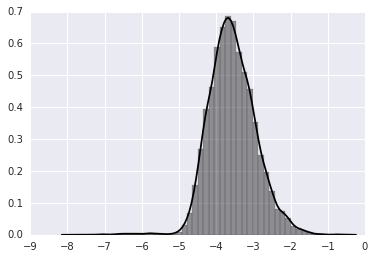

In [130]:
sns.distplot(y + y_mean, color='black')
sns.distplot(model.predict(X_test) + y_mean, color='orange')

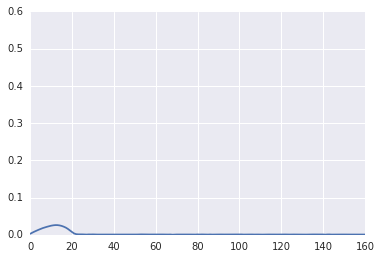

In [131]:
plt.plot(watchlist.epochs, watchlist.scores)
plt.ylim(0, 0.6)
plt.show()

In [91]:
EPOCHS=5

model = Sequential()
model.add(Dense(input_dim=dims, output_dim=1000, init='uniform', W_regularizer=l1(0.005)))
model.add(Dropout(0.01))
model.add(Activation('tanh'))

model.add(Dense(input_dim=1000, output_dim=100, init='uniform', W_regularizer=l1(0.005)))
model.add(Activation('tanh'))

model.add(Dense(input_dim=200, output_dim=100, init='uniform', W_regularizer=l2(0.001)))
model.add(Activation('tanh'))

model.add(Dense(input_dim=100, output_dim=1, init='uniform', W_regularizer=l2(0.001)))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam')

with StatusCallback(epoch_total=EPOCHS) as status:
    model.fit(X, y, nb_epoch=EPOCHS, batch_size=250, callbacks=[status], verbose=0)

In [92]:
y_valid_score = model.predict(X_valid) + y_mean
y_test_score = model.predict(X_test) + y_mean

In [93]:
np.savetxt('submission/flora_valid.predict', y_valid_score, fmt='%0.10f')
np.savetxt('submission/flora_test.predict', y_test_score, fmt='%0.10f')